In [53]:
# Getting the average batting% after 10 games
import os
import pandas as pd

# Folder with CSVs
folder = "test_data/batting_data"

# Collect batting data
all_data = []

# Load and sort CSV files by date from filename
csv_files = sorted(
    [f for f in os.listdir(folder) if f.endswith(".csv")],
    key=lambda x: pd.to_datetime(x.replace(".csv", ""))
)

# Read and append each CSV
for file in csv_files:
    df = pd.read_csv(os.path.join(folder, file))
    all_data.append(df)

# Combine all into one DataFrame
combined_df = pd.concat(all_data, ignore_index=True)

# Group by team abbreviation
tenth_averages = []

for team, group in combined_df.groupby("Team Abbreviation"):
    group = group.sort_values("Date")
    if len(group) >= 10:
        tenth_entry = group.iloc[9]  # 10th row (index 9)
        tenth_averages.append({
            "Team": tenth_entry["Team"],
            "Team Abbreviation": team,
            "10th Date": tenth_entry["Date"],
            "10th Batting Average": tenth_entry["Batting Average"]
        })

# Result as DataFrame
result_df = pd.DataFrame(tenth_averages)

# Display
print(result_df)

            Team Team Abbreviation   10th Date  10th Batting Average
0        Arizona               ARI  2025-04-05              0.271375
1        Atlanta               ATL  2025-04-05              0.189922
2      Baltimore               BAL  2025-04-05              0.266917
3         Boston               BOS  2025-04-05              0.256318
4       Chi Cubs               CHC  2025-04-05              0.243697
5        Chi Sox               CHW  2025-04-05              0.212389
6     Cincinnati               CIN  2025-04-05              0.192157
7      Cleveland               CLE  2025-04-05              0.236842
8       Colorado               COL  2025-04-05              0.215190
9        Detroit               DET  2025-04-05              0.269076
10       Houston               HOU  2025-04-05              0.190698
11   Kansas City               KCR  2025-04-05              0.224490
12     LA Angels               LAA  2025-04-05              0.215190
13    LA Dodgers               LAD

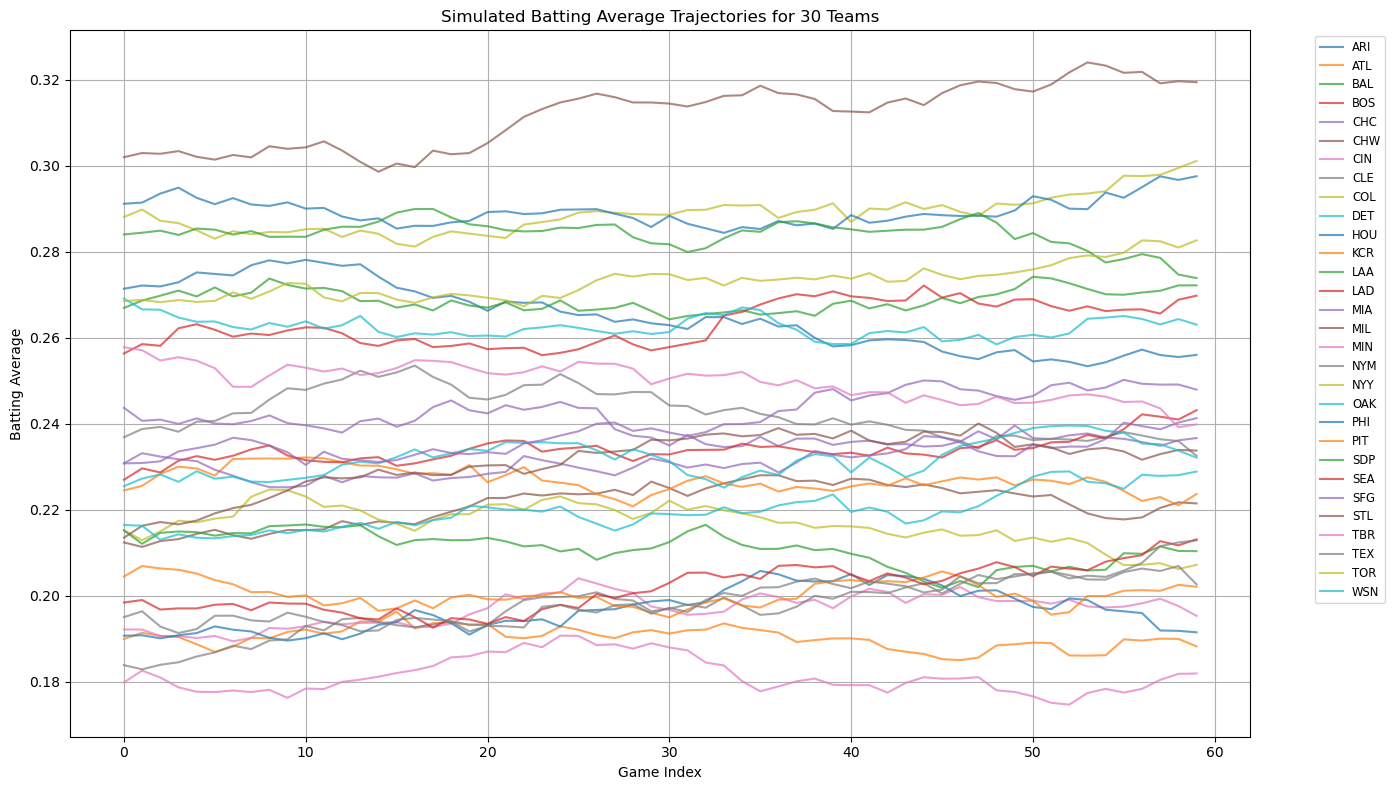

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# --- Simulation Parameters ---
n_games = 60
std_dev = 0.0015  # Fixed standard deviation for batting avg random walk
np.random.seed(42)

# --- Simulate and Plot Batting Trajectories ---
plt.figure(figsize=(14, 8))

for _, row in result_df.iterrows():
    team = row['Team Abbreviation']
    start_val = row['10th Batting Average']

    # Generate random walk
    walk = [start_val]
    for _ in range(1, n_games):
        walk.append(walk[-1] + np.random.normal(0, std_dev))

    plt.plot(walk, label=team, alpha=0.7)

plt.title("Simulated Batting Average Trajectories for 30 Teams")
plt.xlabel("Game Index")
plt.ylabel("Batting Average")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()


In [25]:
import os
import pandas as pd

# Folder containing daily odds data
folder = "test_data/daily_odds"

# Collect all CSV files and sort by date
csv_files = sorted(
    [f for f in os.listdir(folder) if f.endswith(".csv")],
    key=lambda x: pd.to_datetime(x.replace(".csv", ""))
)

# Step 1: Get all unique teams across all CSVs
all_teams = set()
for file in csv_files:
    df = pd.read_csv(os.path.join(folder, file))
    all_teams.update(df['homeTeam'].dropna().unique())
    all_teams.update(df['awayTeam'].dropna().unique())

# Step 2: Initialize tracking dict
team_appearances = {team: [] for team in all_teams}

# Step 3: Loop through files to collect first 10 games per team
for file in csv_files:
    df = pd.read_csv(os.path.join(folder, file))
    df['startDate'] = pd.to_datetime(df['startDate'])

    for _, row in df.iterrows():
        home_team, away_team = row['homeTeam'], row['awayTeam']
        home_pitcher, away_pitcher = row['homePitcher'], row['awayPitcher']
        game_date = row['startDate']

        if len(team_appearances[home_team]) < 10:
            team_appearances[home_team].append({
                'team': home_team,
                'date': game_date,
                'pitcher': home_pitcher,
                'home_or_away': 'home'
            })
        if len(team_appearances[away_team]) < 10:
            team_appearances[away_team].append({
                'team': away_team,
                'date': game_date,
                'pitcher': away_pitcher,
                'home_or_away': 'away'
            })

# Step 4: Flatten and convert to DataFrame
flattened = [entry for appearances in team_appearances.values() for entry in appearances]
result_df = pd.DataFrame(flattened)
result_df = result_df.sort_values(by=["team", "date"]).reset_index(drop=True)

# View or save
print(result_df)
# result_df.to_csv("first_10_pitchers_by_team.csv", index=False)


           team                      date          pitcher home_or_away
0       Arizona 2025-03-28 02:10:00+00:00       Zac Gallen         home
1       Arizona 2025-03-29 01:40:00+00:00    Merrill Kelly         home
2       Arizona 2025-03-30 00:10:00+00:00   Brandon Pfaadt         home
3       Arizona 2025-04-01 23:05:00+00:00    Corbin Burnes         away
4       Arizona 2025-04-02 23:05:00+00:00       Zac Gallen         away
..          ...                       ...              ...          ...
295  Washington 2025-04-04 22:45:00+00:00       Jake Irvin         home
296  Washington 2025-04-05 20:05:00+00:00  Mitchell Parker         home
297  Washington 2025-04-06 17:35:00+00:00  Trevor Williams         home
298  Washington 2025-04-07 22:45:00+00:00   MacKenzie Gore         home
299  Washington 2025-04-08 22:45:00+00:00        Brad Lord         home

[300 rows x 4 columns]


In [37]:
import os
import pandas as pd
from bs4 import BeautifulSoup
from tqdm import tqdm

# ------------- Setup -------------
pitcher_html_folder = "test_data/raw_pitcher_data"
output_rows = []

# Assume you already have a DataFrame `result_df`
result_df['date'] = pd.to_datetime(result_df['date']).dt.tz_localize(None).dt.normalize()
result_df['pitcher'] = result_df['pitcher'].str.strip().str.title()

# List of pitcher names to match
pitcher_names = result_df['pitcher'].unique()

# ----------- ERA Parser -----------
def parse_pitcher_era(filepath):
    with open(filepath, "r", encoding="utf-8") as f:
        soup = BeautifulSoup(f, "html.parser")

    rows = soup.find_all("tr", attrs={"data-index": True})
    data = []
    for row in rows:
        date_tag = row.find("td", {"data-col": "0"})
        era_tag = row.find("td", {"data-col": "5"})
        if not date_tag or not era_tag:
            continue

        date_str = date_tag.get_text(strip=True)
        try:
            full_date = pd.to_datetime(f"2025 {date_str}").tz_localize(None).normalize()
            era_val = era_tag.get_text(strip=True)
            era_val = float(era_val) if era_val.replace('.', '', 1).isdigit() else None
            if era_val is not None:
                data.append((full_date, era_val))
        except Exception:
            continue

    return pd.Series({d: e for d, e in sorted(data)})

# ----------- Match and Append ----------
for pitcher in tqdm(pitcher_names, desc="Matching ERAs"):
    filename = f"{pitcher.lower().replace(' ', '-')}_2025.html"
    filepath = os.path.join(pitcher_html_folder, filename)

    if not os.path.exists(filepath):
        continue

    era_series = parse_pitcher_era(filepath)
    era_series.index = pd.to_datetime(era_series.index).tz_localize(None).sort_values()

    df_subset = result_df[result_df['pitcher'] == pitcher].copy()

    def get_closest_prior_era(game_date):
        game_date = pd.to_datetime(game_date).tz_localize(None).normalize()
        eligible = era_series.index[era_series.index <= game_date]
        return era_series.loc[eligible[-1]] if not eligible.empty else None

    df_subset['matched_ERA'] = df_subset['date'].apply(get_closest_prior_era)
    output_rows.append(df_subset)

# ------------- Output -------------
final_df = pd.concat(output_rows, ignore_index=True)
print("✅ Saved combined results to matched_pitcher_eras.csv")
final_df

Matching ERAs: 100%|██████████| 157/157 [00:13<00:00, 11.62it/s]

✅ Saved combined results to matched_pitcher_eras.csv



/var/folders/hn/7wzd6_fs6wncrcy89b9jdj100000gn/T/ipykernel_83382/4102059469.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat(output_rows, ignore_index=True)


,team,date,pitcher,home_or_away,ERA,matched_ERA
0,Arizona,2025-03-28,Zac Gallen,home,None,9.00
1,Arizona,2025-04-02,Zac Gallen,away,None,3.38
2,Arizona,2025-04-08,Zac Gallen,home,None,5.28
3,Arizona,2025-03-29,Merrill Kelly,home,None,1.69
4,Arizona,2025-04-03,Merrill Kelly,away,None,10.00
...,...,...,...,...,...,...
295,Washington,2025-03-31,Michael Soroka,away,None,7.20
296,Washington,2025-04-01,Trevor Williams,away,None,5.70
297,Washington,2025-04-06,Trevor Williams,home,None,5.40
298,Washington,2025-04-05,Mitchell Parker,home,None,0.73


In [38]:
final_df

,team,date,pitcher,home_or_away,ERA,matched_ERA
0,Arizona,2025-03-28,Zac Gallen,home,None,9.00
1,Arizona,2025-04-02,Zac Gallen,away,None,3.38
2,Arizona,2025-04-08,Zac Gallen,home,None,5.28
3,Arizona,2025-03-29,Merrill Kelly,home,None,1.69
4,Arizona,2025-04-03,Merrill Kelly,away,None,10.00
...,...,...,...,...,...,...
295,Washington,2025-03-31,Michael Soroka,away,None,7.20
296,Washington,2025-04-01,Trevor Williams,away,None,5.70
297,Washington,2025-04-06,Trevor Williams,home,None,5.40
298,Washington,2025-04-05,Mitchell Parker,home,None,0.73


In [40]:
import pandas as pd

# Assuming final_df already exists and includes 'team' and 'matched_ERA'
df = final_df.copy()

# Clean and ensure numeric ERA
df['matched_ERA'] = pd.to_numeric(df['matched_ERA'], errors='coerce')

# Group by team and calculate average over the first 10 games
avg_era_per_team = (
    df.dropna(subset=['matched_ERA'])
      .groupby('team')
      .head(10)  # Ensures only first 10 games per team are used
      .groupby('team')['matched_ERA']
      .mean()
      .reset_index()
      .rename(columns={'matched_ERA': 'avg_era_first_10_games'})
)

# Display result
print(avg_era_per_team)

              team  avg_era_first_10_games
0          Arizona                5.514000
1        Athletics                6.181250
2          Atlanta                4.280000
3        Baltimore                5.057000
4           Boston                5.713000
5        Chi. Cubs                5.470000
6   Chi. White Sox                2.561000
7       Cincinnati                3.064000
8        Cleveland                5.190000
9         Colorado                2.431000
10         Detroit                4.203000
11         Houston                3.522000
12     Kansas City                3.338000
13       LA Angels                4.586000
14      LA Dodgers                3.736000
15           Miami                5.191000
16       Milwaukee                8.031000
17       Minnesota                7.504000
18         NY Mets                2.632000
19      NY Yankees                5.129000
20    Philadelphia                2.355000
21      Pittsburgh                4.340000
22       Sa

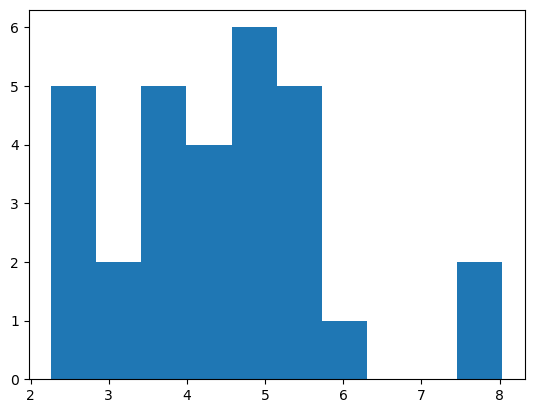

In [43]:
import matplotlib.pyplot as plt

plt.hist(avg_era_per_team['avg_era_first_10_games'])
plt.show()

/var/folders/hn/7wzd6_fs6wncrcy89b9jdj100000gn/T/ipykernel_83382/2344918907.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sort_values("startDate").head(10)['pitch_era'].mean())
Sliding windows per team: 100%|██████████| 31/31 [00:02<00:00, 11.67it/s]


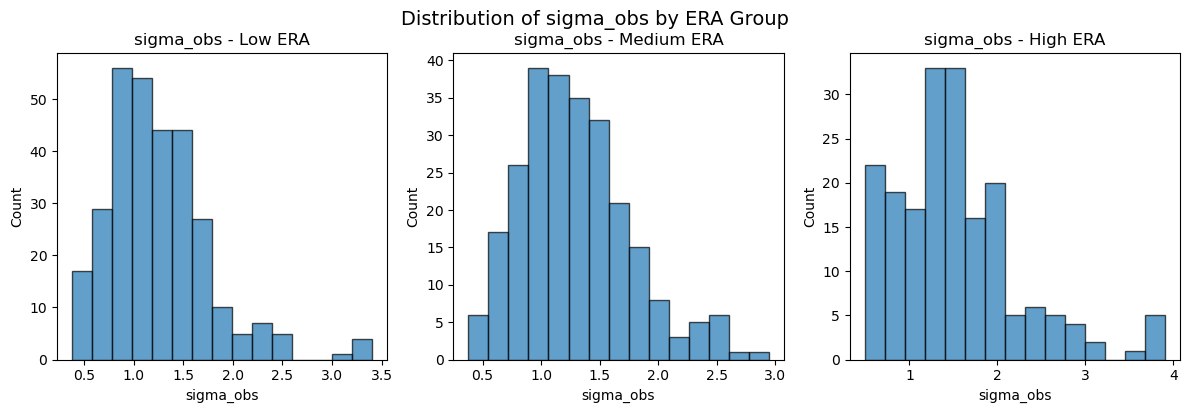

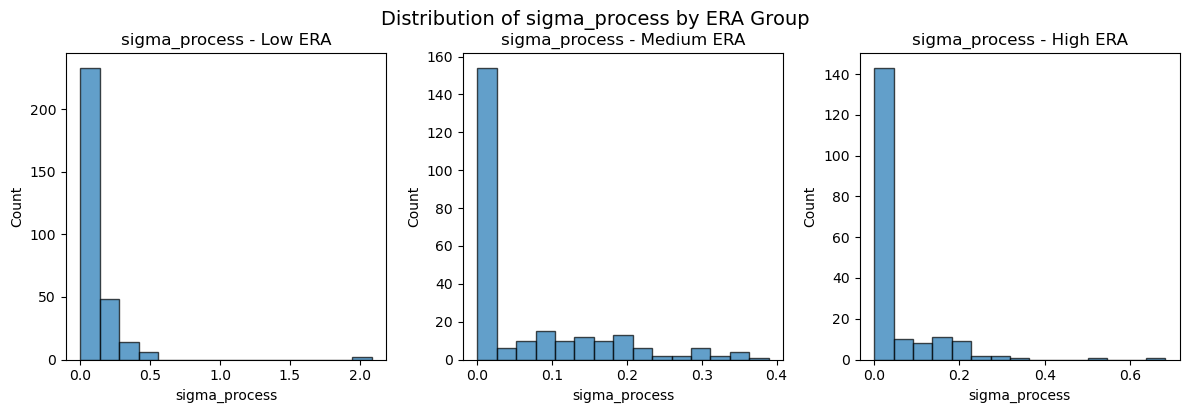

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.structural import UnobservedComponents
from tqdm import tqdm

# Load and prep
data = pd.read_csv("master_df.csv")
data['startDate'] = pd.to_datetime(data['startDate'])
data['year'] = data['startDate'].dt.year

# Combine home/away ERA
home = data[['startDate', 'homeTeam', 'homePitcher_era']].rename(
    columns={'homeTeam': 'team', 'homePitcher_era': 'pitch_era'}
)
away = data[['startDate', 'awayTeam', 'awayPitcher_era']].rename(
    columns={'awayTeam': 'team', 'awayPitcher_era': 'pitch_era'}
)
long_df = pd.concat([home, away], ignore_index=True)
long_df = long_df.dropna(subset=['pitch_era'])
long_df = long_df.sort_values(['team', 'startDate'])

# Compute average ERA over first 10 appearances per team
first_10_era = (
    long_df.groupby("team")
    .apply(lambda x: x.sort_values("startDate").head(10)['pitch_era'].mean())
    .reset_index()
    .rename(columns={0: 'avg_era_10'})
)

# Bin teams into quantiles
first_10_era['group'] = pd.qcut(first_10_era['avg_era_10'], 3, labels=['low', 'medium', 'high'])

# Map group labels to long_df
long_df = long_df.merge(first_10_era[['team', 'group']], on='team', how='left')

# Sliding window settings
WINDOW_SIZE = 30
STEP = 5

# Results
results = []

# Loop through each team
for team, group_df in tqdm(long_df.groupby('team'), desc="Sliding windows per team"):
    group_df = group_df.sort_values('startDate').reset_index(drop=True)
    group_label = group_df['group'].iloc[0]

    if len(group_df) < WINDOW_SIZE or pd.isna(group_label):
        continue

    for start in range(0, len(group_df) - WINDOW_SIZE + 1, STEP):
        window = group_df.iloc[start:start + WINDOW_SIZE]

        try:
            model = UnobservedComponents(window['pitch_era'], level='local level')
            fit_result = model.fit(disp=False)
            sigma_obs = np.sqrt(fit_result.params.get('sigma2.irregular', np.nan))
            sigma_proc = np.sqrt(fit_result.params.get('sigma2.level', np.nan))
            results.append({
                'team': team,
                'group': group_label,
                'sigma_obs': sigma_obs,
                'sigma_process': sigma_proc
            })
        except Exception:
            continue

# Results to DataFrame
results_df = pd.DataFrame(results).dropna()

# Plot histograms for each group
for var in ['sigma_obs', 'sigma_process']:
    plt.figure(figsize=(12, 4))
    for i, grp in enumerate(['low', 'medium', 'high']):
        subset = results_df[results_df['group'] == grp]
        plt.subplot(1, 3, i + 1)
        plt.hist(subset[var], bins=15, edgecolor='black', alpha=0.7)
        plt.title(f'{var} - {grp.capitalize()} ERA')
        plt.xlabel(var)
        plt.ylabel("Count")
    plt.tight_layout()
    plt.suptitle(f"Distribution of {var} by ERA Group", y=1.02, fontsize=14)
    plt.show()


In [49]:
# Define the bins and labels
bins = [0, 3.647, 4.170, 100]
labels = ['low', 'medium', 'high']

# Assign group labels based on avg_era
avg_era_per_team['group'] = pd.cut(
    avg_era_per_team['avg_era_first_10_games'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# Display the result
print(avg_era_per_team)

              team  avg_era_first_10_games   group
0          Arizona                5.514000    high
1        Athletics                6.181250    high
2          Atlanta                4.280000    high
3        Baltimore                5.057000    high
4           Boston                5.713000    high
5        Chi. Cubs                5.470000    high
6   Chi. White Sox                2.561000     low
7       Cincinnati                3.064000     low
8        Cleveland                5.190000    high
9         Colorado                2.431000     low
10         Detroit                4.203000    high
11         Houston                3.522000     low
12     Kansas City                3.338000     low
13       LA Angels                4.586000    high
14      LA Dodgers                3.736000  medium
15           Miami                5.191000    high
16       Milwaukee                8.031000    high
17       Minnesota                7.504000    high
18         NY Mets             

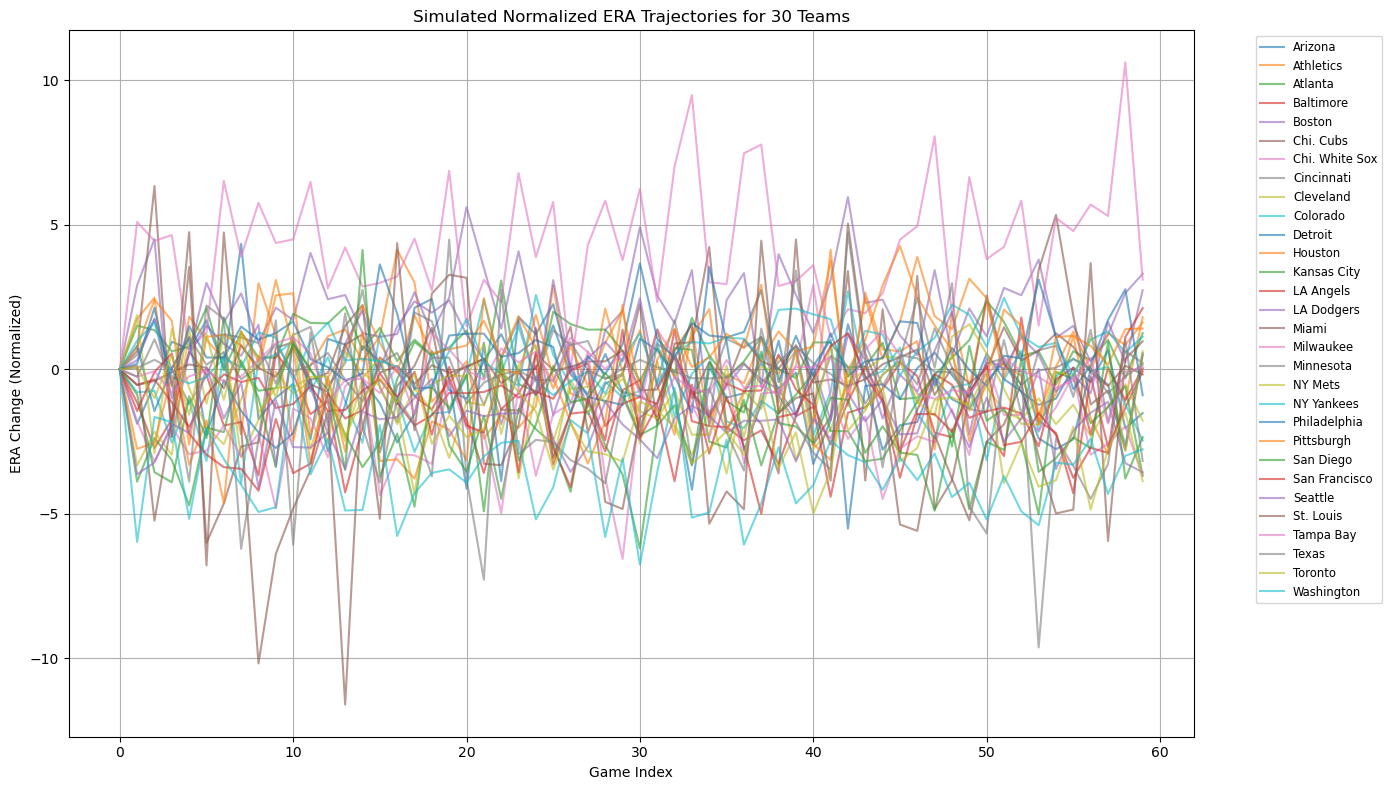

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Make sure these are defined:
# avg_era_per_team: DataFrame with columns ['team', 'avg_era_first_10_games', 'group']
# results_df: DataFrame with ['team', 'group', 'sigma_obs', 'sigma_process']

n_games = 60
np.random.seed(42)

plt.figure(figsize=(14, 8))

for _, row in avg_era_per_team.iterrows():
    team = row['team']
    group = row['group']

    # Filter the distribution to the team's group
    group_data = results_df[results_df['group'] == group]

    # Sample noise values from the group's distribution
    sigma_obs = np.random.choice(group_data['sigma_obs'].values)
    sigma_proc = np.random.choice(group_data['sigma_process'].values)

    # Simulate latent process
    latent = [0.0]
    for _ in range(1, n_games):
        latent.append(latent[-1] + np.random.normal(0, sigma_proc))

    observed = np.array(latent) + np.random.normal(0, sigma_obs, size=n_games)
    observed = observed - observed[0]  # Normalize to start at 0

    plt.plot(observed, label=team, alpha=0.6)

plt.title("Simulated Normalized ERA Trajectories for 30 Teams")
plt.xlabel("Game Index")
plt.ylabel("ERA Change (Normalized)")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()
